In [1]:
# from mm_rag.embeddings.bridgetower_embeddings import (
#     BridgeTowerEmbeddings
# )
import json
import os
import sys

import lancedb
from PIL import Image

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from multimodal_lancedb import MultimodalLanceDB

/Users/maxkut/Documents/projects/multimodal_rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def load_json_file(file_path):
    # Open the JSON file in read mode
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


def display_retrieved_results(results):
    print(f"There is/are {len(results)} retrieved result(s)")
    print()
    for i, res in enumerate(results):
        print(
            f'The caption of the {str(i+1)}-th retrieved result is:\n"{results[i].page_content}"'
        )
        print()
        display(Image.open(results[i].metadata["extracted_frame_path"]))
        print("------------------------------------------------------------")

In [3]:
# declare host file
LANCEDB_HOST_FILE = ".lancedb"
# declare table name
TBL_NAME = "test_tbl"
# initialize vectorstore
db = lancedb.connect(LANCEDB_HOST_FILE)

In [4]:
# load metadata files
vid1_metadata_path = "../data/videos/metadata.json"
vid1_metadata = load_json_file(vid1_metadata_path)

# collect transcripts and image paths
vid1_trans = [vid["transcript"] for vid in vid1_metadata]
vid1_img_path = [vid["extracted_frame_path"] for vid in vid1_metadata]

In [5]:
# Update transcripts to include n neighboring chunks
# for video1, we pick n = 7
n = 7
updated_vid1_trans = [
    " ".join(vid1_trans[i - int(n / 2) : i + int(n / 2)])
    if i - int(n / 2) >= 0
    else " ".join(vid1_trans[0 : i + int(n / 2)])
    for i in range(len(vid1_trans))
]

# also need to update the updated transcripts in metadata
for i in range(len(updated_vid1_trans)):
    vid1_metadata[i]["transcript"] = updated_vid1_trans[i]

In [6]:
# example
print(f'A transcript example before update:\n"{vid1_trans[6]}"')
print()
print(f'After update:\n"{updated_vid1_trans[6]}"')

A transcript example before update:
"the ECC is a 56 day course that is"

After update:
"it's an answer to what is the communicator of the future the expeditionary Communications course or the ECC is a 56 day course that is designed to make corporals through gruny sergeants proficient in the 0600"


In [7]:
# Ingest into LanceDB
# initialize an BridgeTower embedder
# from importlib import reload
# import embeddings_helper
# reload(embeddings_helper)
from embeddings_helper import CLIPEmbeddings

embedder = CLIPEmbeddings()


# you can pass in mode="append"
# to add more entries to the vector store
# in case you want to start with a fresh vector store,
# you can pass in mode="overwrite" instead

_ = MultimodalLanceDB.from_text_image_pairs(
    texts=updated_vid1_trans,
    image_paths=vid1_img_path,
    embedding=embedder,
    metadatas=vid1_metadata,
    connection=db,
    table_name=TBL_NAME,
    mode="overwrite",
)

/var/folders/zq/01yz_srd79b766fdct7w3n600000gn/T/ipykernel_41774/823682999.py:6: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from embeddings_helper import CLIPEmbeddings
100%|██████████| 56/56 [00:49<00:00,  1.13it/s]


In [8]:
## Inspect table

import pandas as pd

# open a connection to table TBL_NAME
tbl = db.open_table(TBL_NAME)

print(f"There are {tbl.to_pandas().shape[0]} rows in the table")
# display the first 3 rows of the table
tbl.to_pandas()[["text", "image_path"]].head(9)

There are 10 rows in the table


,text,image_path
0,[Music] the expeditionary Communicator came fr...,../data/videos/extracted_frame/frame_0.jpg
1,[Music] the expeditionary Communicator came fr...,../data/videos/extracted_frame/frame_1.jpg
2,[Music] the expeditionary Communicator came fr...,../data/videos/extracted_frame/frame_2.jpg
3,[Music] the expeditionary Communicator came fr...,../data/videos/extracted_frame/frame_3.jpg
4,the expeditionary Communicator came from the 2...,../data/videos/extracted_frame/frame_4.jpg
5,the 2018 common outs planning guidance it's an...,../data/videos/extracted_frame/frame_5.jpg
6,it's an answer to what is the communicator of ...,../data/videos/extracted_frame/frame_6.jpg
7,communicator of the future the expeditionary C...,../data/videos/extracted_frame/frame_7.jpg
8,expeditionary Communications course or the ECC...,../data/videos/extracted_frame/frame_8.jpg


In [10]:
# Creating a LanceDB vector store
vectorstore = MultimodalLanceDB(
    uri=LANCEDB_HOST_FILE, embedding=embedder, table_name=TBL_NAME
)

# creating a retriever for the vector store
# search_type="similarity"
#  declares that the type of search that the Retriever should perform
#  is similarity search
# search_kwargs={"k": 1} means returning top-1 most similar document
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 1})

There is/are 1 retrieved result(s)

The caption of the 1-th retrieved result is:
"effectively carry out a C2 architecture by teaching configuring implementing and maintaining small form factor Network and Data Systems Marines also be trained in the network fundamentals integrating into the global Network and their"



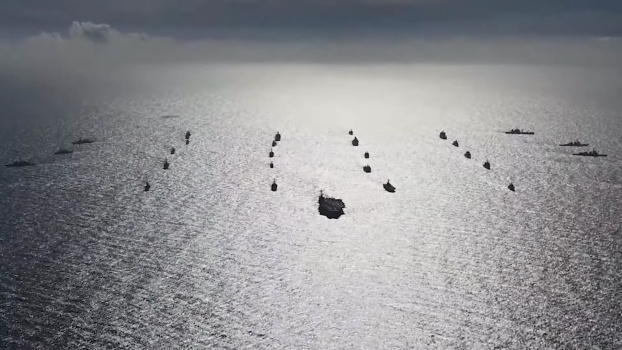

------------------------------------------------------------


In [32]:
query1 = "a ship"
results = retriever.invoke(query1)
display_retrieved_results(results)

There is/are 3 retrieved result(s)

The caption of the 1-th retrieved result is:
"effectively carry out a C2 architecture by teaching configuring implementing and maintaining small form factor Network and Data Systems Marines also be trained in the network fundamentals integrating into the global Network and their"



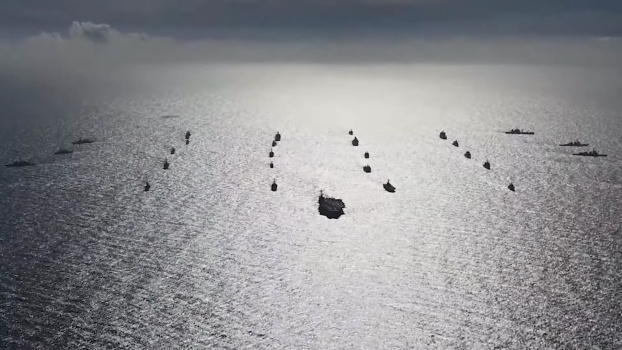

------------------------------------------------------------
The caption of the 2-th retrieved result is:
"in the execution of each element of communications and how these skills apply to force [Applause] design the ECC has five phases Each of which teaches the core discipline of"



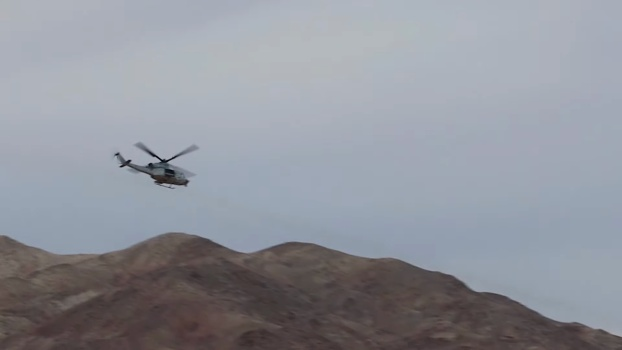

------------------------------------------------------------
The caption of the 3-th retrieved result is:
"[Music] the expeditionary Communicator came from the 2018 common outs planning guidance it's an answer to what is the communicator of the future the"



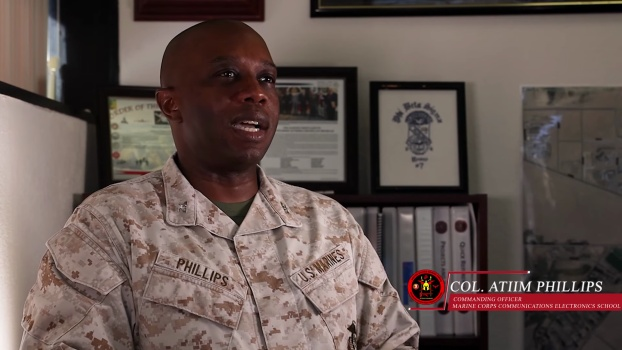

------------------------------------------------------------


In [33]:
# ask to return top 3 most similar documents
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})
results = retriever.invoke(query1)
display_retrieved_results(results)